## Import and Set Up

In [54]:
import streamlit as st
import pandas as pd
import requests
import plotly.express as px
from datetime import datetime
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os
%matplotlib inline


In [55]:
# Base URLs
CURRENT_WEATHER_URL = "https://api.openweathermap.org/data/2.5/weather"
FORECAST_URL = "https://api.openweathermap.org/data/2.5/forecast"

In [56]:
# Set API key here
load_dotenv()  # Load variables from .env file
API_KEY = os.getenv("OPENWEATHER_API_KEY")

## Functions for getting location

In [57]:
def get_user_location():
    city = input("Enter city name: ").strip()
    state = input("Enter state code (optional): ").strip()
    country = input("Enter country code (e.g., US, GB): ").strip()
    
    # Construct the location string
    location = f"{city},{state},{country}" if state else f"{city},{country}"
    return location


## Function to retrieve current weather of given location.

In [58]:
def fetch_current_weather(location):
    url = f'{CURRENT_WEATHER_URL}?q={location}&appid={API_KEY}&units=metric'
    response = requests.get(url)
    data = response.json()
    
    if response.status_code != 200:
        print(f"Error fetching data: {data.get('message', 'Unknown error')}")
        return None
    
    #print(data)

    weather_info = {
        'City': data['name'],
        'Temperature (°C)': data['main']['temp'],
        'Humidity (%)': data['main']['humidity'],
        'Wind Speed (m/s)': data['wind']['speed'], 
        'feels_like (°C)': data['main']['feels_like'], 
        'temp_min (°C)': data['main']['temp_min'], 
        'temp_max (°C)': data['main']['temp_max'],                       
        'Description': data['weather'][0]['description'].title()
    }    

    return pd.DataFrame([weather_info])

## Function to retrieve forecast weather of given location

In [59]:
def fetch_forecast(location):
    url = f'{FORECAST_URL}?q={location}&appid={API_KEY}&units=metric'
    response = requests.get(url)
    data = response.json()

    if response.status_code != 200:
        print(f"Error fetching forecast: {data.get('message', 'Unknown error')}")
        return None

    forecast_list = data['list']
    #print(forecast_list)

    forecast_df = pd.DataFrame([{
        'DateTime': item['dt_txt'],
        'Temperature (°C)': item['main']['temp'],
        'Humidity (%)': item['main']['humidity'],
        'feels_like (°C)': item['main']['feels_like'], 
        'temp_min (°C)': item['main']['temp_min'], 
        'temp_max (°C)': item['main']['temp_max'],
        'wind (m/s)': item['wind']['speed'], 
        #'visibility': item['visibility'],
        'Weather': item['weather'][0]['description'].title()
    } for item in forecast_list])

    forecast_df['DateTime'] = pd.to_datetime(forecast_df['DateTime'])
    forecast_df['Date'] = forecast_df['DateTime'].dt.date

    return forecast_df

## Summarize forecast report Generation

In [60]:
def summarize_forecast(forecast_df):
    summary_df = forecast_df.groupby('Date').agg({
        'Temperature (°C)': ['mean', 'min', 'max'],
        'Humidity (%)': 'mean',
        'wind (m/s)': 'mean',
        'Weather': lambda x: x.mode()[0] if not x.mode().empty else None
    }).reset_index()

    summary_df.columns = ['Date', 'Avg Temp (°C)', 'Min Temp (°C)', 'Max Temp (°C)', 
                          'Avg Humidity (%)', 'Avg Wind (m/s)', 'Most Common Weather']
    return summary_df


##  Visualization Function

In [61]:
def visualize_summary_1(summary_df):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Temperature Plot
    summary_df.plot(x='Date', y=['Min Temp (°C)', 'Avg Temp (°C)', 'Max Temp (°C)'],
                    kind='line', marker='o', ax=ax[0])
    ax[0].set_title('Temperature Trends')
    ax[0].set_ylabel('°C')

    # Humidity and Wind
    ax2 = ax[1]
    ax2.bar(summary_df['Date'], summary_df['Avg Humidity (%)'], alpha=0.6, label='Avg Humidity (%)')
    ax2.plot(summary_df['Date'], summary_df['Avg Wind (m/s)'], color='red', marker='s', label='Avg Wind (m/s)')
    ax2.set_title('Humidity and Wind Trends')
    ax2.set_ylabel('% / m/s')
    ax2.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [62]:
def visualize_summary_2(summary_df):
    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")

    # Plot Temperature
    plt.subplot(1, 2, 1)
    sns.lineplot(x='Date', y='Avg Temp (°C)', data=summary_df, marker='o', color='tomato')
    plt.title('Average Temperature (°C) Over Days')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Plot Humidity
    plt.subplot(1, 2, 2)
    sns.lineplot(x='Date', y='Avg Humidity (%)', data=summary_df, marker='o', color='dodgerblue')
    plt.title('Average Humidity (%) Over Days')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.suptitle("5-Day Weather Forecast Summary", fontsize=16, fontweight='bold', y=1.05)
    plt.show()


In [63]:

def interactive_visualize_summary(summary_df):
    fig = px.line(summary_df, x='Date', y=['Avg Temp (°C)', 'Avg Humidity (%)'],
                  title='Interactive Daily Weather Summary',
                  markers=True)
    fig.update_layout(xaxis_title='Date', yaxis_title='Value')
    fig.show()
    fig.write_html("interactive_summary.html")
    print("Interactive plot saved as interactive_summary.html")


### Display Summary

In [64]:
def display_summary_styled(summary_df):
    styled_df = summary_df.style.background_gradient(subset=['Avg Temp (°C)'], cmap='coolwarm') \
                                 .background_gradient(subset=['Avg Humidity (%)'], cmap='Blues') \
                                 .set_caption("Daily Weather Summary")
    display(styled_df)  # Use display() if in Jupyter, else styled_df.to_html() for web
    visualize_summary_1(summary_df)
    visualize_summary_2(summary_df)
    interactive_visualize_summary(summary_df)  


In [65]:
def display_summary(summary_df):
    print("\n Daily Weather Summary:")
    print(tabulate(summary_df, headers='keys', tablefmt='fancy_grid', showindex=False))  
    

### Main Function


 Fetching current weather...
    City  Temperature (°C)  Humidity (%)  Wind Speed (m/s)  feels_like (°C)  \
0  Mason             23.68            85              1.54            24.32   

   temp_min (°C)  temp_max (°C)    Description  
0          22.57          24.92  Broken Clouds  

 Fetching 5-day forecast...

 Forecast Preview:
             DateTime  Temperature (°C)  Humidity (%)  feels_like (°C)  \
0 2025-08-20 03:00:00             23.68            85            24.32   
1 2025-08-20 06:00:00             23.60            88            24.31   
2 2025-08-20 09:00:00             20.79            93            21.35   
3 2025-08-20 12:00:00             20.12            92            20.59   
4 2025-08-20 15:00:00             21.98            78            22.27   

   temp_min (°C)  temp_max (°C)  wind (m/s)          Weather        Date  
0          23.68          24.15        2.70       Light Rain  2025-08-20  
1          23.44          23.60        2.22       Light Rain  2025-08

,Date,Avg Temp (°C),Min Temp (°C),Max Temp (°C),Avg Humidity (%),Avg Wind (m/s),Most Common Weather
0,2025-08-20,23.020000,20.120000,25.880000,79.571429,3.631429,Overcast Clouds
1,2025-08-21,21.857500,19.090000,27.290000,74.375000,4.030000,Overcast Clouds
2,2025-08-22,21.203750,15.230000,29.090000,74.375000,2.535000,Clear Sky
3,2025-08-23,22.633750,17.450000,29.260000,68.875000,2.265000,Clear Sky
4,2025-08-24,20.765000,15.560000,25.640000,69.000000,3.257500,Clear Sky
5,2025-08-25,19.710000,19.710000,19.710000,57.000000,4.140000,Clear Sky


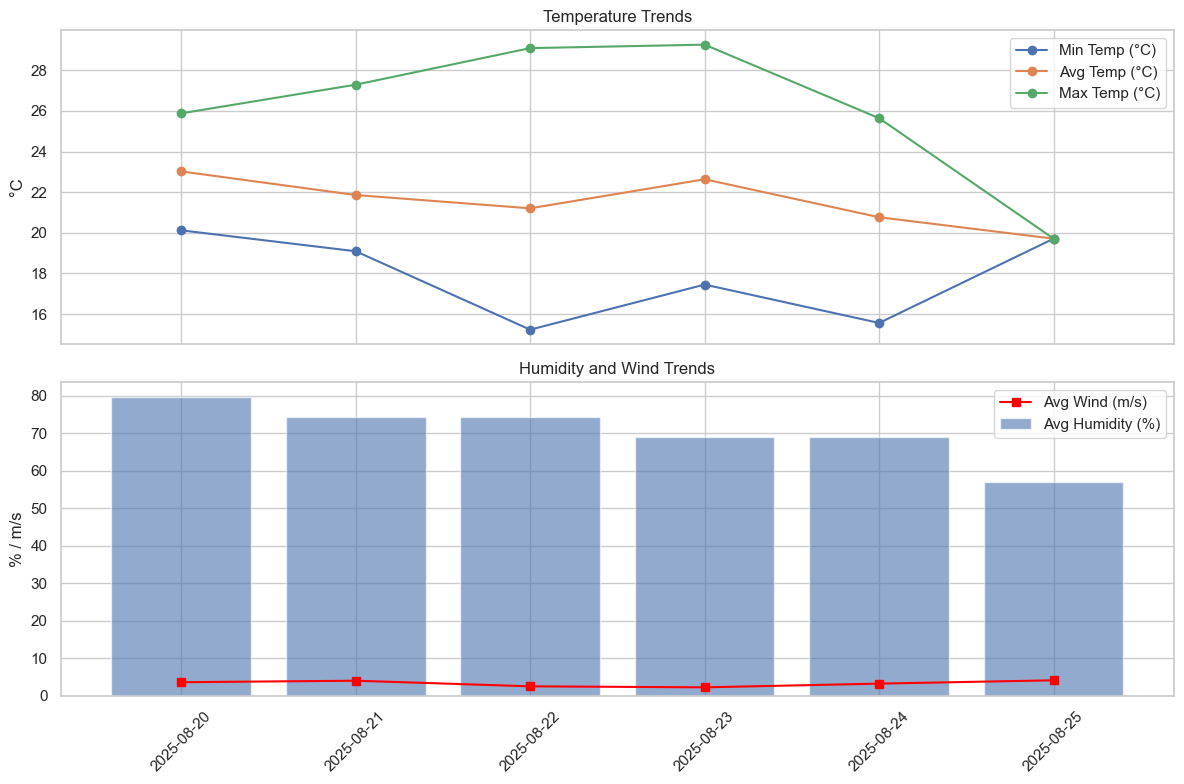

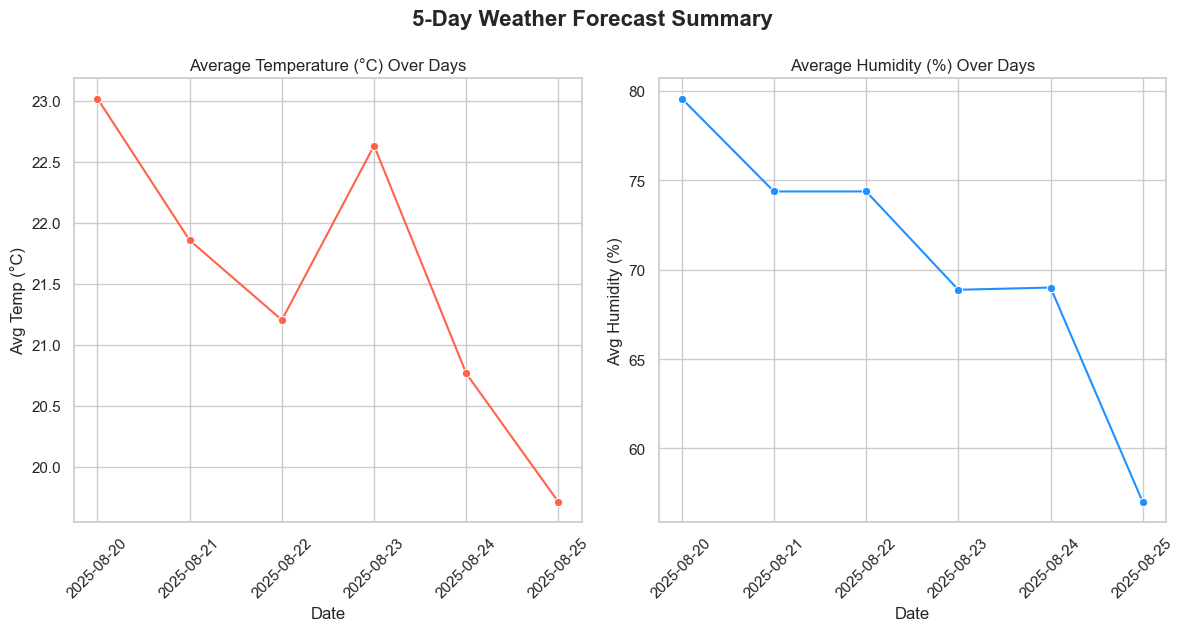

Interactive plot saved as interactive_summary.html


In [66]:
def main():
    location = get_user_location()

    print("\n Fetching current weather...")
    current_weather = fetch_current_weather(location)
    if current_weather is not None:
        print(current_weather)

    print("\n Fetching 5-day forecast...")
    forecast = fetch_forecast(location)
    if forecast is not None:
        print("\n Forecast Preview:")
        print(forecast.head())

        print("\n Daily Summary:")
        summary = summarize_forecast(forecast)
        display_summary_styled(summary)
        # display_summary(summary)
      
# Run the program
if __name__ == "__main__":
    main()


Interactive Summary can be viewed [here](https://sahiladevi.github.io/Weather_Dashboard/interactive_summary.html)
